# Image Classification Using VGG16 Deep Learning

## Dataset Link:

[Chest X-Ray Images (Pneumonia) Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

### Table of Content
- [Data Analysis](#section-1)
- [Balance The Data](#section-2)
- [Data Preprocessing](#section-3)
- [Train The Model](#section-4)
- [Result](#section-5)

In [1]:
import numpy as np
import cv2
import pandas as pd
import os
import glob
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


## Data Analysis<a id="section-1"></a>

In [2]:
train_path = []
path_label = []
for directory_path in glob.glob("./chest_xray/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in tqdm(glob.glob(os.path.join(directory_path,"*.jpeg"))):
        train_path.append(img_path)
        path_label.append(label)


NORMAL


100%|█████████████████████████████████████████████████████████████████████████| 1341/1341 [00:00<00:00, 1342697.94it/s]


PNEUMONIA


100%|█████████████████████████████████████████████████████████████████████████| 3875/3875 [00:00<00:00, 1938564.89it/s]


In [3]:
list_of_tuples = list(zip(train_path, path_label))
df = pd.DataFrame(list_of_tuples,
                  columns=['Image Path', 'Labels'])
df.head()

,Image Path,Labels
0,./chest_xray/train\NORMAL\IM-0115-0001.jpeg,NORMAL
1,./chest_xray/train\NORMAL\IM-0117-0001.jpeg,NORMAL
2,./chest_xray/train\NORMAL\IM-0119-0001.jpeg,NORMAL
3,./chest_xray/train\NORMAL\IM-0122-0001.jpeg,NORMAL
4,./chest_xray/train\NORMAL\IM-0125-0001.jpeg,NORMAL


In [4]:
df.Labels.value_counts()

PNEUMONIA    3875
NORMAL       1341
Name: Labels, dtype: int64

<AxesSubplot:>

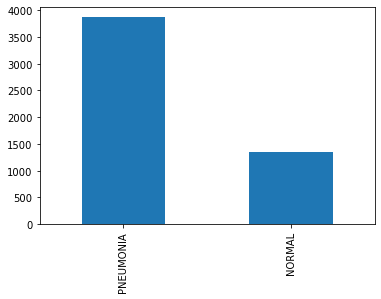

In [5]:
df.Labels.value_counts().plot(kind='bar')

## Data Undersampling <a id="section-2"></a>

In [6]:
# Creating a DataFrame for 'normal' class
df_normal = df[df['Labels'] == 'NORMAL']

# Creating a DataFrame for 'pneumonia' class
df_pneumonia = df[df['Labels'] == 'PNEUMONIA']

In [7]:
# Assuming you have two lists of image paths and their corresponding class labels
normal_images = df_normal['Image Path']  # List of image paths for NORMAL class
pneumonia_images = df_pneumonia['Image Path']  # List of image paths for PNEUMONIA class

normal_labels = ['NORMAL'] * len(normal_images)  # Assign 'NORMAL' label to each image
pneumonia_labels = ['PNEUMONIA'] * len(pneumonia_images)  # Assign 'PNEUMONIA' label to each image

# Determine the size of the smaller class (NORMAL)
pneumonia_count = len(pneumonia_images)
normal_count = len(normal_images)
min_count = min(pneumonia_count, normal_count)

# Undersample the PNEUMONIA class to match the size of the NORMAL class
undersampled_pneumonia_images = np.random.choice(np.array(pneumonia_images), size=min_count, replace=False)
undersampled_pneumonia_labels = np.random.choice(np.array(pneumonia_labels), size=min_count, replace=False)

# Combine the undersampled PNEUMONIA images with the original NORMAL images
balanced_images = np.concatenate((np.array(normal_images), undersampled_pneumonia_images))
balanced_labels = np.concatenate((np.array(normal_labels), undersampled_pneumonia_labels))

# Shuffle the combined data while preserving the image-label pairs
combined_data = list(zip(balanced_images, balanced_labels))
np.random.shuffle(combined_data)

# Separate the shuffled image-label pairs back into separate arrays or lists
shuffled_images, shuffled_labels = zip(*combined_data)
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)


In [8]:
d = Counter(shuffled_labels)
print(d)
 
new_list = list([item for item in d if d[item]>1])
print(new_list)

Counter({'NORMAL': 1341, 'PNEUMONIA': 1341})
['NORMAL', 'PNEUMONIA']


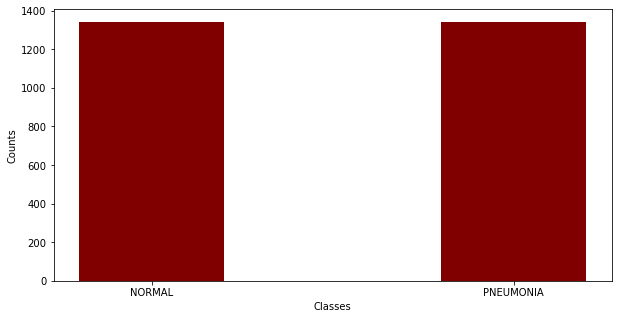

In [9]:
classes = list(d.keys())
values = list(d.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.show()

## Data Preprocessing<a id="section-3"></a>

In [10]:
train_images = []
train_labels = []
size = 224

for img_path in tqdm(shuffled_images):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img,(size,size))
    train_images.append(img)

train_images = np.array(train_images)
train_labels = np.array(shuffled_labels)

100%|██████████████████████████████████████████████████████████████████████████████| 2682/2682 [01:20<00:00, 33.19it/s]


In [11]:
test_images = []
test_labels = []
size = 224

for directory_path in glob.glob("./chest_xray/test/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in tqdm(glob.glob(os.path.join(directory_path,"*.jpeg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(size,size))
        test_images.append(img)
        test_labels.append(label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

NORMAL


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:04<00:00, 53.97it/s]


PNEUMONIA


100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:03<00:00, 102.41it/s]


In [12]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2682, 224, 224, 3), (2682,), (624, 224, 224, 3), (624,))

In [13]:
no_of_classes = len(np.unique(train_labels))

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [15]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

## Train The Model <a id="section-4"></a>

<img src="./images/0_vixsAVM-GWzT4H06.png" alt="class" border="0">

In [16]:
base_model = VGG16(weights='imagenet', include_top=False,input_shape = (224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=10,validation_split=0.1)

Train on 2413 samples, validate on 269 samples
Epoch 1/10
2413/2413 [==============================] - 23s 10ms/sample - loss: 0.8145 - accuracy: 0.4969 - val_loss: 0.8040 - val_accuracy: 0.5093
Epoch 2/10
2413/2413 [==============================] - 16s 7ms/sample - loss: 0.8143 - accuracy: 0.4990 - val_loss: 0.8040 - val_accuracy: 0.5093
Epoch 3/10
2413/2413 [==============================] - 17s 7ms/sample - loss: 0.8143 - accuracy: 0.4990 - val_loss: 0.8040 - val_accuracy: 0.5093
Epoch 4/10
2413/2413 [==============================] - 16s 7ms/sample - loss: 0.8143 - accuracy: 0.4990 - val_loss: 0.8040 - val_accuracy: 0.5093
Epoch 5/10
2413/2413 [==============================] - 16s 7ms/sample - loss: 0.8143 - accuracy: 0.4990 - val_loss: 0.8040 - val_accuracy: 0.5093
Epoch 6/10
2413/2413 [==============================] - 16s 6ms/sample - loss: 0.8143 - accuracy: 0.4990 - val_loss: 0.8040 - val_accuracy: 0.5093
Epoch 7/10
2413/2413 [==============================] - 16s 7ms/sample

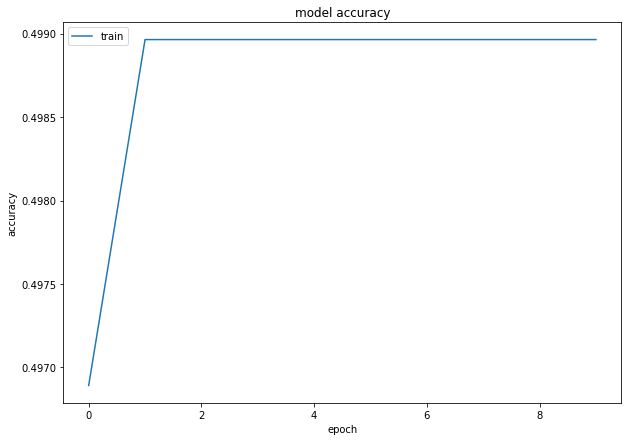

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

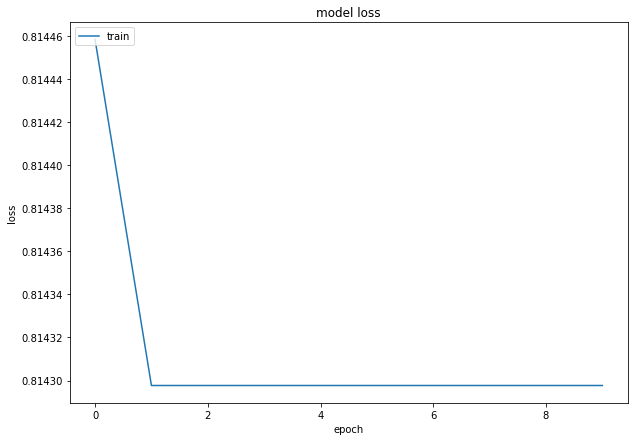

In [19]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Result <a id="section-5"></a>

In [20]:
#model.save("vgg_model.h5")
# load model
loaded_model = load_model('vgg_model.h5')

In [21]:
y_pred = loaded_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred=le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.97      0.62      0.76       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



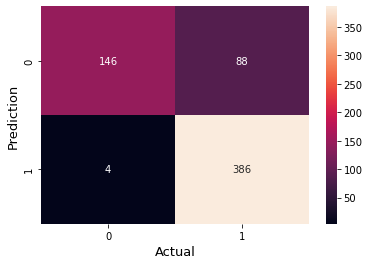

In [23]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix.
sns.heatmap(cm,annot=True,fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

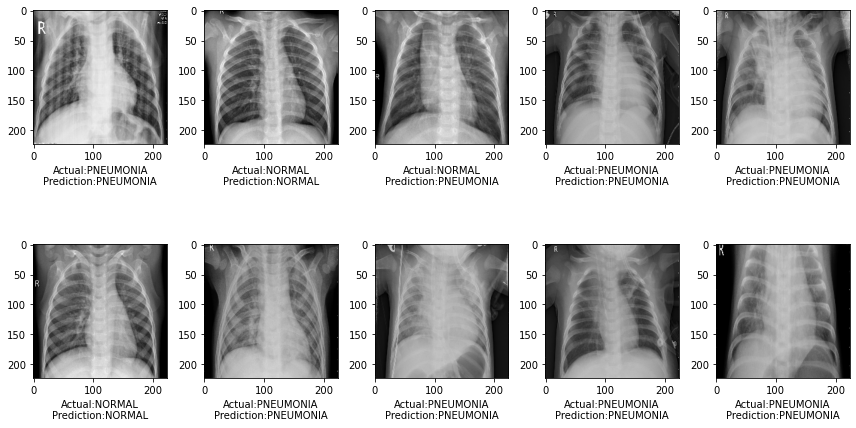

In [24]:
import random
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(category,pred_category))
#plt.savefig('result.png')
plt.tight_layout() 